# comparing insert size and cpa per case

This notebook creates a a pandas dataframe containing summary statistics for the insert size and cpa per case. The dataframe is saved as a csv file.

In [23]:
import sys
#add directory to path to allow importing of modules if not already in path
if "/home/d.gaillard/source/NIPTov-analysis-tools" not in sys.path:
    sys.path.append("/home/d.gaillard/source/NIPTov-analysis-tools")


import WCR_analysis_tools
from importlib import reload
reload(WCR_analysis_tools)
from WCR_analysis_tools import *

In [24]:
# load CPA per case
import pandas as pd
from pathlib import Path
def get_CPA_from_wiseX(list_of_statfiles):
    """
    Function to extract CPA scores from statistics text files from WISECONDORX outputs
    """

    ids = [statfile.stem.split('_')[0] for statfile in list_of_statfiles]
    cpa_scores = []
    for statfile in list_of_statfiles:
        with open(statfile) as f:
            last_line = f.readlines()[-1]
            cpa_score = float(last_line.split(':')[-1].replace('\n', ''))
            cpa_scores.append(cpa_score)

    df = pd.DataFrame(
        {
            'PGDXID': ids,
            'cpa_score_PE': cpa_scores
        }).set_index('PGDXID')

    return df

base_path = Path('/home/d.gaillard/paired_ovarian/snakemake-wisecondorx-loocv/output_folder/outfiles')

list_of_statfiles = list(base_path.joinpath('benign').glob("*looref_statistics.txt"))
cpa_benign = get_CPA_from_wiseX(list_of_statfiles)


list_of_statfiles = list(base_path.joinpath('malignant').glob("*ref_benign_statistics.txt"))
cpa_malignant = get_CPA_from_wiseX(list_of_statfiles)

cpa_benign['label'] = 0
cpa_malignant['label'] = 1
cpa_df = pd.concat([cpa_malignant,cpa_benign]).reset_index()

# load HE4 and RMI
import numpy as np
dfclin = pd.read_spss("/home/d.gaillard/paired_ovarian/clinical_data/NIPT-clinical_he4_data.sav")
dfclin.rename(columns={'Barcode' : 'barcode'}, inplace=True)
dfclin.rename(columns={'Studienummer' : 'studienummer'}, inplace=True)

dfclin = dfclin.loc[:, ['studienummer','barcode','HE4', 'RMI']]
dfclin['log_HE4'] = np.log(dfclin['HE4'] + 1)
dfclin['log_RMI'] = np.log(dfclin['RMI'] + 1)
dfclin['studienummer'] = dfclin['studienummer'].astype('int').astype('str')

# labels df
labels = pd.read_csv('/home/d.gaillard/paired_ovarian/label_data/labels.csv', dtype="string")
labels.rename(columns={'Patient_ID_1' : 'studienummer'}, inplace=True)

# merge clin df, labels and paired-CPA
df = pd.merge(dfclin, labels, on='studienummer')
df = pd.merge(df, cpa_df, on='PGDXID')

# combine with SE results
SE_results = pd.read_csv('/home/d.gaillard/paired_ovarian/single_end_results/cpa_per_case_SE.csv')
SE_results.rename(columns={"cpa_score" : "cpa_score_SE"}, inplace=True)
df = pd.merge(df, SE_results, on='barcode', suffixes=['_df', '_SE'])
df = df.fillna(df.mean())
df['log_cpa_score_PE'] = np.log(df['cpa_score_PE'])
df['log_cpa_score_SE'] = np.log(df['cpa_score_SE'])


/tmp/ipykernel_1293887/3827701543.py:61: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())


In [25]:
# get mean insert size per case
df_insertsize_statistics = pd.read_csv('/home/d.gaillard/paired_ovarian/fragment_lengh_distibution/summary_statistics/summary_statistics.csv')
# convert sample name to PGDXID
df_insertsize_statistics['PGDXID'] = df_insertsize_statistics['sample'].str.split('_').str[0]

# merge with df on PGDXID
df = pd.merge(df, df_insertsize_statistics, on='PGDXID')


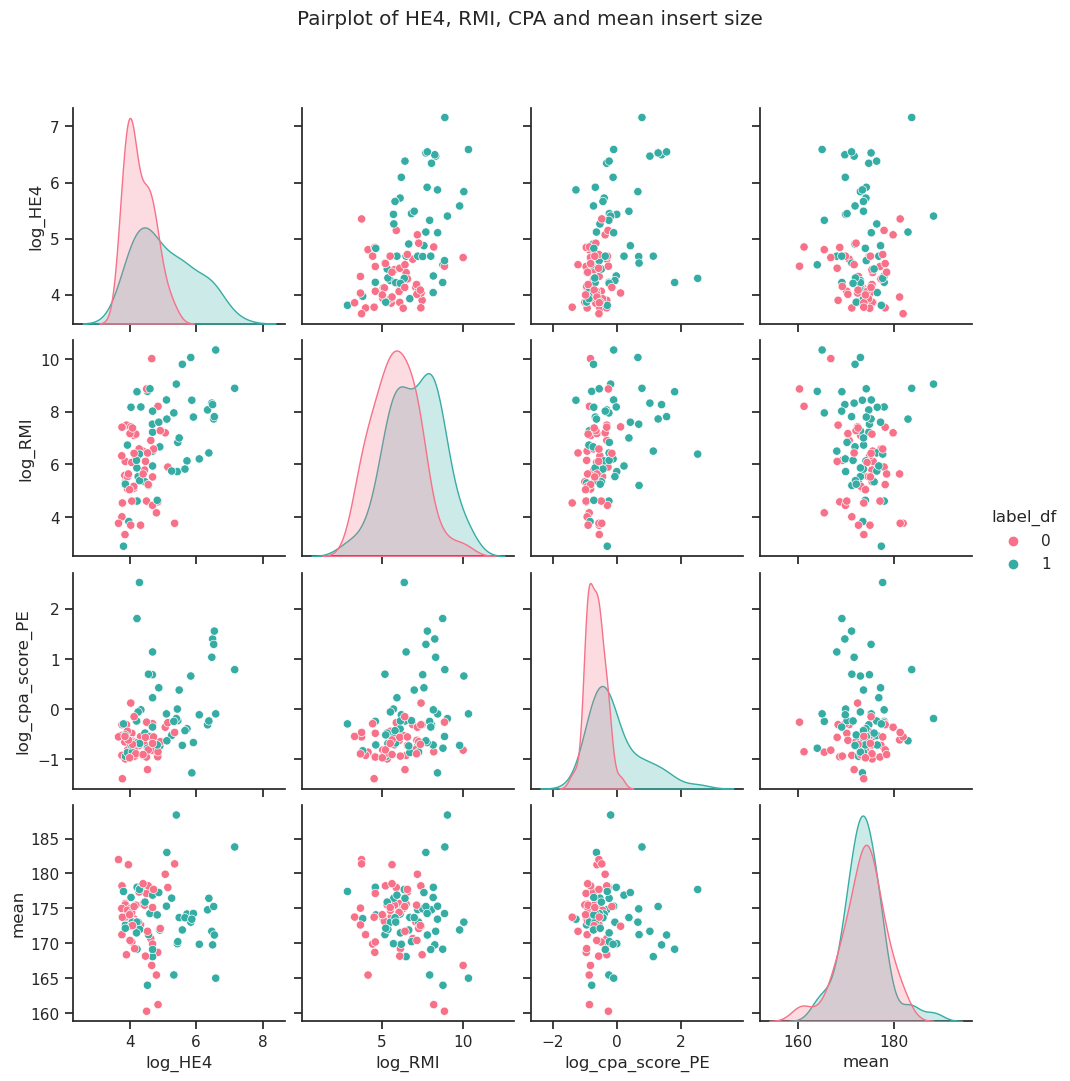

In [26]:
# generate a pairplot with seaborn of: HE4, RMI, CPA, mean insert size
import seaborn as sns
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df, vars=["log_HE4", "log_RMI", "log_cpa_score_PE", "mean"], hue="label_df", palette="husl")
g.fig.suptitle("Pairplot of HE4, RMI, CPA and mean insert size", y=1.08)
plt.show()

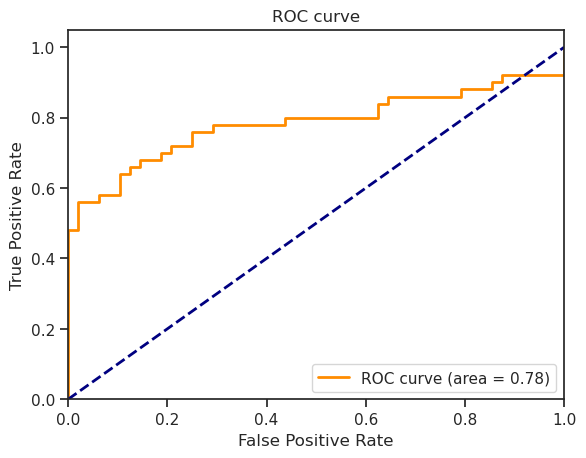

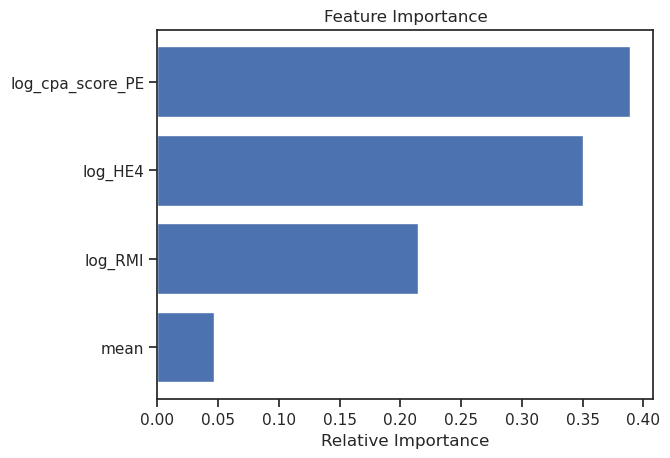

In [33]:
# use sklrean to train a random forest classifier on log_HE4, log_RMI, log_cpa_score_PE, mean
from sklearn.ensemble import RandomForestClassifier
# use cross_val_predict with leave one out to get a prediction for each case
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut

X = df.loc[:, ['log_HE4', 'log_cpa_score_PE', 'mean', 'log_RMI']]
y = df['label_df'].astype('int')

clf = RandomForestClassifier(n_estimators=500, max_depth=2, random_state=0)
y_pred = cross_val_predict(clf, X, y, cv=LeaveOneOut(), method='predict_proba')[:,1]

# plot roc curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()


# train a random forest classifier on the ful dataset and report feature importance
clf = RandomForestClassifier(n_estimators=500, max_depth=2, random_state=0)
clf.fit(X, y)
# generate barplot of feature importance
importances = clf.feature_importances_
# names of the features
names = X.columns
# sort the features by importance
sorted_idx = np.argsort(importances)
# sort names and importances
names = names[sorted_idx]
importances = importances[sorted_idx]

# plot the feature importance
plt.figure()
plt.title("Feature Importance")
plt.barh(range(X.shape[1]), importances, align="center")
plt.yticks(range(X.shape[1]), names)
plt.xlabel("Relative Importance")
plt.show()